# Creating a Directed Graph of the IDS Lab's Scaled Smart City

**Goal**: Output a mathematical graph in matrix form representing all road segments in the city and their connections. The graph must be directed since each road segment can only be travelled in one direction. The graph will be used to test pathfinding algorithms (A*, etc.).

**Approach**: In order to construct the graph, we must determine which segments connect to each other. The starting files divided the segments into lines and arcs, and imagined them plotted onto a 2D plane. The files included the following info for each:

Lines:
*   (x,y) of the startpoint
*   Direction (+X, -X, +Y, -Y)
*   Length
*   Index ("S" + a number)

Arcs:
*   (x,y) of the centerpoint of the circle the arc lies on
*   radius of the circle
*   start and end angle, in radians
*   Direction (CW, CCW)
*   Index ("A" + a number)

In order to find which segments connect to each other, we first need to calculate the start and endpoints of every segment. 

Because we want to use the graph to find paths between points, not segments, we need to organize the graph by nodes, or points where 2+ segments connect. Additionally, since not all the calculated start and endpoints had exactly the same coordinates due to slight rounding differences, inaccuracies, etc, we needed to consider points within one lane-width of each other as corresponding to the same node. Therefore, we make a list of all potential nodes from all calculated start and endpoints. Then, we remove duplicates and keep only one node for points within one lane of each other to get the  abbreviated list of nodes.

With this finalized list of nodes, we assign the start and endpoint of each segment to a node. We can also find how many segments intersect at each node - it should be at least 2 and not more than 4, since the intersections with the most possible options consist of entering by one segment and exiting by three possible turn options.

With this information, we can then assemble the matrices. We construct one (node_matrix) to allow us to find whether two nodes are connected, and another (segment_matrix) to allow us to find whether two segments are connected. The two matrices contain the same information, but are formatted inversely as a matter of conveinence depending on the use case.

See part 2 of this project, creating a scalable last mile delivery algorithm, [here](https://colab.research.google.com/drive/1BchaBODiajZHHzTW7vMgZnYn4y6zlGVl?usp=sharing).

The paper's website is available [here](https://sites.google.com/view/ud-ids-lab/lmds).

# 1. Upload files

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import numpy as np

In [ ]:
# starting files accessible here: https://drive.google.com/drive/folders/1GhHAlR9pDz6iKACB9w1an1Qhu0rKnIlX?usp=sharing
from google.colab import files
import io

uploaded = files.upload()
line_df = pd.read_csv(io.BytesIO(uploaded['originalLines.csv']))
arc_df = pd.read_csv(io.BytesIO(uploaded['originalArcs.csv']))


Saving originalArcs.csv to originalArcs (3).csv
Saving originalLines.csv to originalLines (3).csv


In [ ]:
# Convert file columns to numeric types
conversions = ['length','x','y'];
for x in conversions:
  line_df[x] = pd.to_numeric(line_df[x], downcast='float')

conversions = ['radius','x','y','angleStart','angleEnd'];
for x in conversions:
  arc_df[x] = pd.to_numeric(arc_df[x], downcast='float')

# 2. Calculate Start/Endpoints of Segments

In [ ]:
# sets end x/y coordinates of every line's endpoint based on given direction and length
for index, row in line_df.iterrows():
  if line_df.loc[index,'direction'] == '-X':
    line_df.loc[index, 'x_end'] = (line_df.loc[index, 'x'] + line_df.loc[index, 'length'])
  elif line_df.loc[index,'direction'] == '+X':
    line_df.loc[index, 'x_end'] = (line_df.loc[index, 'x'] - line_df.loc[index, 'length'])
  else:
    line_df.loc[index, 'x_end'] = (line_df.loc[index, 'x'])


for index, row in line_df.iterrows():
  if line_df.loc[index,'direction'] == '-Y':
    line_df.loc[index, 'y_end'] = (line_df.loc[index, 'y'] + line_df.loc[index, 'length'])
  elif line_df.loc[index,'direction'] == '+Y':
    line_df.loc[index, 'y_end'] = (line_df.loc[index, 'y'] - line_df.loc[index, 'length'])
  else:
    line_df.loc[index, 'y_end'] = (line_df.loc[index, 'y'])


In [ ]:
# flip the start and end angles of arcs that are clockwise
for index, row in arc_df.iterrows():
  if arc_df.loc[(index, 'Rotation')] == 'CW':
    temp = arc_df.loc[(index,'angleStart')]
    arc_df.loc[(index,'angleStart')] = arc_df.loc[(index,'angleEnd')]
    arc_df.loc[(index,'angleEnd')] = temp

# convert arc angle values from radians to degrees
arc_df['angleStartDegrees'] = round(arc_df.angleStart * (180/math.pi),2)
arc_df['angleEndDegrees'] = round(arc_df.angleEnd * (180/math.pi),2)

# calculate startpoints of arcs - extra math needed because arcs' given (x,y) points are centerpoints of circles
for index, row in arc_df.iterrows():
  arc_df.loc[index,'x_StartAdjust'] = round(arc_df.loc[index, 'radius'] * math.sin((math.pi/2) - arc_df.loc[index,'angleStart']),2)
  arc_df.loc[index,'y_StartAdjust'] = round(arc_df.loc[index, 'radius'] * math.sin( arc_df.loc[index,'angleStart'] ),2)

for index, row in arc_df.iterrows():
  arc_df.loc[index,'x_start'] = round(arc_df.loc[index,'x'] + arc_df.loc[index,'x_StartAdjust'], 2)
  arc_df.loc[index,'y_start'] = round(arc_df.loc[index,'y'] + arc_df.loc[index,'y_StartAdjust'], 2)

# calculate endpoints of arcs - extra math needed because arcs' given (x,y) points are centerpoints of circles
for index, row in arc_df.iterrows():
  arc_df.loc[index,'x_endadjust'] = round(arc_df.loc[index, 'radius'] * math.sin( (math.pi/2) - arc_df.loc[index,'angleEnd'] ), 2)
  arc_df.loc[index,'y_endadjust'] = round(arc_df.loc[index, 'radius'] * math.sin( arc_df.loc[index,'angleEnd'] ),2)

for index, row in arc_df.iterrows():
  arc_df.loc[index,'x_end'] = round(arc_df.loc[index,'x'] + arc_df.loc[index,'x_endadjust'], 2)
  arc_df.loc[index,'y_end'] = round(arc_df.loc[index,'y'] + arc_df.loc[index,'y_endadjust'],2)


In [ ]:
# convert calculated coordinates (x_start, y_start), (x_end, y_end) to numeric in the line_df and arc_df dataframes
conversions = ['x_end','y_end'];
for x in conversions:
  line_df[x] = pd.to_numeric(line_df[x], downcast='float')

conversions = ['x_start','y_start'];
for x in conversions:
  arc_df[x] = pd.to_numeric(arc_df[x], downcast='float')

# consistently round all coordinate values to 2 decimal places
line_df['x_end'] = round((line_df['x_end']), 2)
line_df['y_end'] = round((line_df['y_end']), 2)
line_df['x_start'] = round((line_df['x']), 2)
line_df['y_start'] = round((line_df['y']), 2)

# add x_start and y_start cols to line_df to make naming consistent for both lines and arcs
line_df['x_start'] = line_df.x
line_df['y_start'] = line_df.y

#create combined df containing both arcs and lines
dfs = [arc_df,line_df]
combined_df = pd.concat(dfs)

In [ ]:
line_df.head()

,index,direction,length,x,y,x_end,y_end,x_start,y_start
0,S1,-X,1.63,0.228,-4.296,1.86,-4.30,0.228,-4.296
1,S2,+X,1.63,1.858,-4.136,0.23,-4.14,1.858,-4.136
2,S3,-X,0.46,-0.232,-4.296,0.23,-4.30,-0.232,-4.296
3,S4,+X,0.46,0.228,-4.136,-0.23,-4.14,0.228,-4.136
4,S5,-X,1.57,-1.802,-4.296,-0.23,-4.30,-1.802,-4.296


In [ ]:
arc_df.head()

,index,x,y,radius,angleStart,angleEnd,Rotation,angleStartDegrees,angleEndDegrees,x_StartAdjust,y_StartAdjust,x_start,y_start,x_endadjust,y_endadjust,x_end,y_end
0,A1,1.858,-3.686,0.61,-1.5708,0.0000,CCW,-90.0,0.0,-0.0,-0.61,1.86,-4.30,0.61,0.0,2.47,-3.69
1,A2,0.228,-3.986,0.30,-3.1416,-1.5708,CCW,-180.0,-90.0,-0.3,0.00,-0.07,-3.99,-0.00,-0.3,0.23,-4.29
2,A3,-0.232,-3.986,0.30,-1.5708,0.0000,CCW,-90.0,0.0,-0.0,-0.30,-0.23,-4.29,0.30,0.0,0.07,-3.99
3,A4,-1.802,-3.986,0.30,-3.1416,-1.5708,CCW,-180.0,-90.0,-0.3,0.00,-2.10,-3.99,-0.00,-0.3,-1.80,-4.29
4,A5,-2.262,-3.986,0.30,-1.5708,0.0000,CCW,-90.0,0.0,-0.0,-0.30,-2.26,-4.29,0.30,0.0,-1.96,-3.99


#3. Make node_df containing all points connecting segments


In [ ]:
# make node_df containing start and endpoints of all segments
temp_df = combined_df[['x_start', 'y_start','index']].copy()
temp_df2 = combined_df[['x_end', 'y_end','index']].copy()
temp_df2['x_start'] = temp_df2['x_end']
temp_df2['y_start'] = temp_df2['y_end']

dfs2 = [temp_df,temp_df2]
node_df = pd.concat(dfs2)

node_df = node_df.drop(['x_end','y_end'],axis=1)

In [ ]:
#drop duplicate nodes (those with identical x/y coordinates) 
node_df = node_df.drop_duplicates()
node_df = node_df.drop_duplicates(subset = ["x_start",'y_start'])

print(len(node_df))
node_df.tail()

382


,x_start,y_start,index
91,0.71,0.76,S91
92,0.73,0.91,S92
94,-0.87,1.22,S94
95,-0.66,0.76,S95
96,-0.64,0.91,S96


# 4. Condense Nodes that are close together

In [ ]:
#resetting indexes to be the same 
node_df = node_df.reset_index(drop=True)
combined_df = combined_df.reset_index(drop=True)

In [ ]:
# condense all nodes

# traverse through node_df, checking for nodes within .13 (the width of a lane)
node_df["x_start"] = round(node_df['x_start'],2)
node_df["y_start"] = round(node_df['y_start'],2)

for index, row in node_df.iterrows():
  for index2, row2 in node_df.iterrows():
    if (index != index2):
      x1 = node_df.loc[(index, 'x_start')]
      y1 = node_df.loc[(index, 'y_start')]
      x2 = node_df.loc[(index2, 'x_start')]
      y2 = node_df.loc[(index2, 'y_start')]
      
      distance = math.sqrt((x1-x2)**2 + (y1-y2)**2)
      if (distance < 0.13) & (distance != 0):
        node_df.loc[(index,'x_start')] = node_df.loc[(index2,'x_start')]
        node_df.loc[(index,'y_start')] = node_df.loc[(index2,'y_start')]


In [ ]:
# for some reason the start coords and end coords are in different datatypes. this fixes that so it can properly compare segment points and node points
combined_df['x_start'] = np.float64(combined_df['x_start'])
combined_df['y_start'] = np.float64(combined_df['y_start'])

# assign unique id value to each node
node_df['id'] = 0
count = 0

for index, row in node_df.iterrows():
  node_df.loc[(index,'id')] = count
  count += 1

node_df.tail()

,x_start,y_start,index,id
377,0.71,0.76,S91,377
378,0.73,0.91,S92,378
379,-0.87,1.22,S94,379
380,-0.66,0.76,S95,380
381,-0.64,0.91,S96,381


In [ ]:
# Change segment coordinates to match reduced node points' coordinates

combined_df['foundStartNode'] = -1
combined_df['foundEndNode'] = -1

# for segment start/endpoints that didn't have an exact match, change them to a node within .13
for index, row in combined_df.iterrows():
  if combined_df.loc[(index, 'foundStartNode')] == -1:
      for index2, row2 in node_df.iterrows():
        x1 = combined_df.loc[(index, 'x_start')]
        y1 = combined_df.loc[(index, 'y_start')]
        x2 = node_df.loc[(index2, 'x_start')]
        y2 = node_df.loc[(index2, 'y_start')]
        distance = math.sqrt((x1-x2)**2 + (y1-y2)**2)

        if (distance < 0.13):
          combined_df.loc[(index, 'x_start')] = node_df.loc[(index2, 'x_start')]
          combined_df.loc[(index, 'y_start')] = node_df.loc[(index2, 'y_start')]
          break
          
  if combined_df.loc[(index, 'foundEndNode')] == -1:
      for index2, row2 in node_df.iterrows():
        x1 = combined_df.loc[(index, 'x_end')]
        y1 = combined_df.loc[(index, 'y_end')]
        x2 = node_df.loc[(index2, 'x_start')]
        y2 = node_df.loc[(index2, 'y_start')]
        distance = math.sqrt((x1-x2)**2 + (y1-y2)**2)

        if (distance < 0.13):
          combined_df.loc[(index, 'x_end')] = node_df.loc[(index2, 'x_start')]
          combined_df.loc[(index, 'y_end')] = node_df.loc[(index2, 'y_start')]
          break


In [ ]:
# for every arc/line in combined_df, checek if the start/endpoints directly match one of the nodes in node_df
combined_df['foundStartNode'] = -1
combined_df['foundEndNode'] = -1

for index, row in combined_df.iterrows():
  for index2, row2 in node_df.iterrows():

    if (combined_df.loc[(index,'x_start')] == node_df.loc[(index2,'x_start')]) and (combined_df.loc[(index,'y_start')] == node_df.loc[(index2,'y_start')]):
      combined_df.loc[(index, 'foundStartNode')] = node_df.loc[(index2,'id')]


    if (combined_df.loc[(index,'x_end')] == node_df.loc[(index2,'x_start')]) and combined_df.loc[(index,'y_end')] == node_df.loc[(index2,'y_start')]:
      combined_df.loc[(index, 'foundEndNode')] = node_df.loc[(index2,'id')]

# calculate arc length of all arcs
combined_df['arc_length'] = (abs(combined_df.angleStart - combined_df.angleEnd)/ (2*math.pi) ) *(2*math.pi)*(combined_df.radius)

In [ ]:
node_df = node_df.drop_duplicates(subset = ["x_start",'y_start'])

# assign new unique id value to each node
node_df['id'] = 0
count = 0
for index, row in node_df.iterrows():
  node_df.loc[(index,'id')] = count
  count += 1

#resetting indexes to be the same 
node_df = node_df.reset_index(drop=True)
combined_df = combined_df.reset_index(drop=True)

print(len(node_df))
node_df.tail()

149


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,x_start,y_start,index,id
144,2.16,-0.21,S88,144
145,0.71,0.76,S89,145
146,0.73,0.91,S90,146
147,-0.87,0.76,S95,147
148,-0.87,0.91,S96,148


# Determine Number of Intersections per Node

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d5047c9d0>]],
      dtype=object)

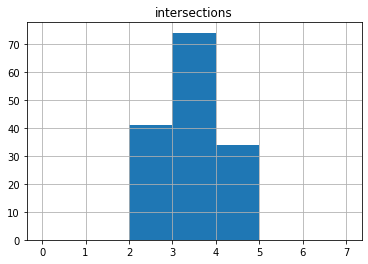

In [ ]:
# Finds number of arcs/lines connected to each node (only startpoints) (47 secs)
node_df['intersections'] = 0
for index, row in combined_df.iterrows():
  for index2, row2 in node_df.iterrows():
    if combined_df.loc[index]['x_start'] == node_df.loc[index2]['x_start']:
      if combined_df.loc[index]['y_start'] == node_df.loc[index2]['y_start']:
  
        node_df.loc[ (index2, 'intersections')] += 1

#find number of arcs/lines at each (x,y) point (only endpoints) (47 secs)
for index, row in combined_df.iterrows():
  for index2, row2 in node_df.iterrows():
    if combined_df.loc[index]['x_end'] == node_df.loc[index2]['x_start']:
      if combined_df.loc[index]['y_end'] == node_df.loc[index2]['y_start']:
       
        node_df.loc[ (index2, 'intersections')] += 1

# graph distribution of how many segments intersect at each node (2 to 4)
node_df.hist(column='intersections',bins = [0,1,2,3,4,5,6,7])


# Set Speed Limits

In [ ]:
# add cols for speed limits and time to travel based on speed limit
combined_df['speed_limit'] = 0
combined_df['adjusted_length'] = 0 # adjusted_length = distance / speed, giving proportional travel time

# set speed limits: 30 for lines, 15 for arcs
for index, row in combined_df.iterrows():
  if combined_df.loc[(index, "radius")] > 0: # arcs:
    combined_df.loc[(index, 'speed_limit')] = 15
    combined_df.loc[(index, 'adjusted_length')] = (combined_df.loc[(index, 'arc_length')] / combined_df.loc[(index, 'speed_limit')])
  else: # lines:
    combined_df.loc[(index, 'speed_limit')] = 30
    combined_df.loc[(index, 'adjusted_length')] = (combined_df.loc[(index, 'length')] / combined_df.loc[(index, 'speed_limit')])


# Create CSV's to export

In [ ]:
# creating clean arc and line df's without extraneous columns
new_arc_df = combined_df[combined_df['radius'] > 0]
new_line_df = combined_df.dropna(subset=['direction'])

new_arc_df = new_arc_df.drop(['angleStartDegrees', 'angleEndDegrees','x_StartAdjust','y_StartAdjust','x_endadjust','y_endadjust','direction','arc_length'], axis=1)
new_line_df = new_line_df.drop(['Rotation', 'radius', 'angleStart', 'angleEnd', 'angleStartDegrees', 'angleEndDegrees','x_StartAdjust','y_StartAdjust','x_endadjust','y_endadjust','direction','arc_length'], axis=1)

new_arc_df = new_arc_df.rename(columns={"foundStartNode": "start_node", "foundEndNode": "end_node"})
new_line_df = new_line_df.rename(columns={"foundStartNode": "start_node", "foundEndNode": "end_node"})

# node_matrix = pd.DataFrame(matrix) 


In [ ]:
# create node_matrix with rows/cols representing nodes...
# where segment id means the 1st node connects directionally to 2nd node through that segment

matrix = []

for index, row in node_df.iterrows(): # for each node, create row
  matrix.append([])

for index, row in node_df.iterrows(): # for each node
  for index3, row in node_df.iterrows(): # for each node
    matrix[index].append(0)

  for index2, row2 in combined_df.iterrows(): # go through all segments and check if they have a startpoint at the current node

    if combined_df.loc[(index2, 'foundStartNode')] == node_df.loc[(index, 'id')]:
      matrix[index][combined_df.loc[(index2, 'foundStartNode')]] = combined_df.loc[(index2, 'index')]
  
# node_matrix_df = pd.DataFrame(matrix) 
# node_matrix_df.tail()

In [ ]:
# create segment_matrix with rows/cols representing segments...
# where 1 means 1st segment connects directionally to 2nd segment
segment_matrix = []

for index, row in combined_df.iterrows(): # for each segment, create row
 segment_matrix.append([])

for index, row in combined_df.iterrows(): # for each row, add a zero for each segment
  for index3, row in combined_df.iterrows(): 
    segment_matrix[index].append(0)

  for index2, row2 in combined_df.iterrows(): # go through all segments and check if they have a startpoint at the current node

    if combined_df.loc[(index, 'foundEndNode')] == combined_df.loc[(index2, 'foundStartNode')]:
      segment_matrix[index][index2] = 1

segment_matrix_df = pd.DataFrame(segment_matrix) 
segment_matrix_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# convert df's to downloadable csv's

# from google.colab import files
# node_df.to_csv('nodes.csv') 
# files.download('nodes.csv')

# new_arc_df.to_csv('arcs.csv') 
# files.download('arcs.csv')

# new_line_df.to_csv('lines.csv')
# files.download('lines.csv')

# segment_matrix_df.to_csv('segment_matrix.csv')
# files.download('segment_matrix.csv')

# node_matrix.to_csv('node_matrix.csv') 
# files.download('node_matrix.csv')

# Visualizations

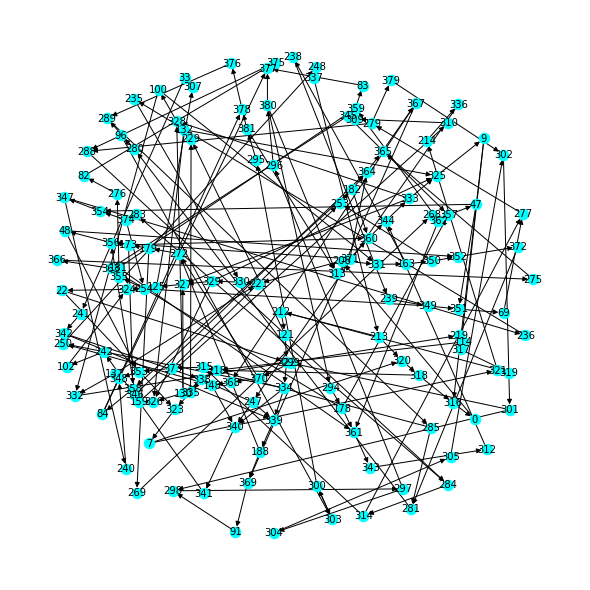

In [ ]:
# creating graph representation using NetworkX (only used for visual)
G = nx.DiGraph() 

for index, row in combined_df.iterrows():
  G.add_edge(combined_df.loc[(index, 'foundStartNode')],combined_df.loc[(index, 'foundEndNode')], weight = combined_df.loc[(index, 'length')])

pos = nx.spring_layout(G)

plt.figure(3,figsize=(8,8)) 
nx.draw(G,pos,node_size=110,font_size=10, node_color="cyan", with_labels = True)
plt.show()

Text(0.5, 1.0, 'Nodes, Color Coded by Number of Adjacent Edges')

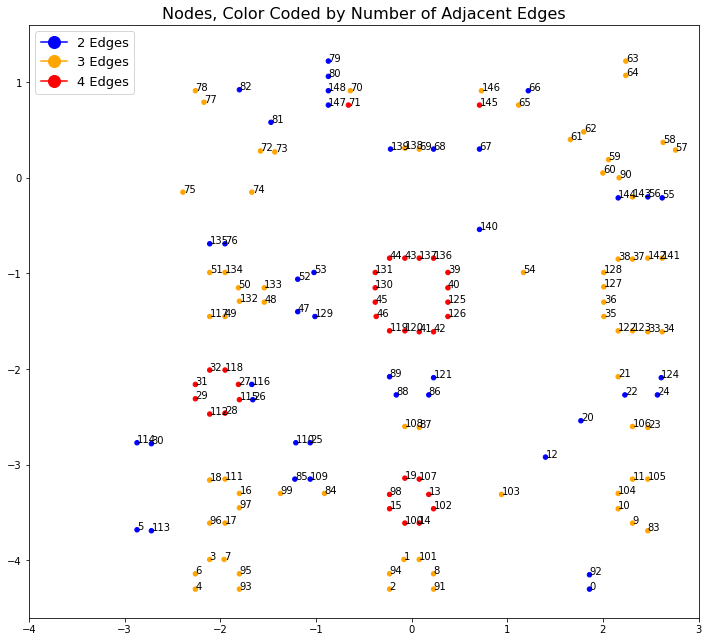

In [ ]:
# plotting nodes, color coded by number of intersecting segments
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

x1 = node_df['x_start']
y1 = node_df['y_start']
colors = node_df['intersections']
labels = node_df['id']
alt_colors = []

legend_elements = [
                  Line2D([0], [0], marker='o', color='blue', label='2 Edges', markersize=12),
                  Line2D([0], [0], marker='o', color='orange', label='3 Edges', markersize=12),
                  Line2D([0], [0], marker='o', color='red', label='4 Edges', markersize=12),
                  ]

for color in colors:
  if color == 4:
    alt_colors.append('red')
  elif color == 3:
    alt_colors.append('orange')
  else:
    alt_colors.append('blue') 

fig = plt.figure()
fig.set_size_inches(12, 12)

ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')
ax.legend(handles=legend_elements, loc='upper left', prop={'size': 13})

annotations = node_df['id']
ax.set_aspect('equal', adjustable='box') 
for i, label in enumerate(annotations):
    plt.annotate(label, (x1[i], y1[i]))

plt.xlim(-4,3)
plt.ylim(-4.6,1.6)
plt.scatter(x1, y1, s=20, c=alt_colors)
plt.title("Nodes, Color Coded by Number of Adjacent Edges",fontsize=16)

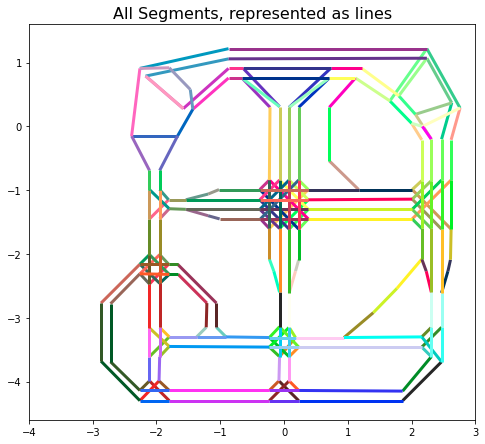

In [ ]:
# plotting all segments as lines in different colors
import numpy as np
import pylab as pl
from matplotlib import collections  as mc
lines = []
c = []
line_count = .1
arc_count = .1
r = .15
g = .15
b = .15
annotations = combined_df['index']

temp_range = []
for index, row in combined_df.iterrows():
# for index in temp_range:
    lines.append([(combined_df.loc[(index, 'x_start')], combined_df.loc[(index, 'y_start')] ), (combined_df.loc[(index, 'x_end')], combined_df.loc[(index, 'y_end')] )])
    if combined_df.loc[(index,'length')] > 0:
      c.append((r,g,b))
      # if line_count < .9:
      #   line_count += .1
      # else:
      #   line_count = .1
      if r < .9:
        r += .2
      elif g < .9:
        g += .2
        r = 0
      elif b < .9:
        b += .2
        g = 0
      else:
        r = .15
        g = .15
        b = .15
    else:
      c.append((r,g,b))
      if r < .9:
        r += .2
      elif g < .9:
        g += .2
        r = 0
      elif b < .9:
        b += .2
        g = 0
      else:
        r = .15
        g = .15
        b = .15

X = (combined_df['x_start'] + combined_df['x_end'])/2
Y = (combined_df['y_start'] + combined_df['y_end'])/2

lc = mc.LineCollection(lines, colors=c, linewidths=3)
fig, ax = plt.subplots()
ax.add_collection(lc)

plt.xlim(-4,3)
plt.ylim(-4.6,1.6)
ax.set_aspect('equal', adjustable='box') 
fig.set_size_inches(8, 8)
plt.title("All Segments, represented as lines",fontsize=16)
plt.show()
